# RADISTAT Demo

RADISTAT is a program that segments a medical image into superpixels and calculates metrics on those
superpixels.

It uses the SLIC algorithm to create clusters out of the image.

To demonstrate RADISTAT, first we import relevant libraries.

In [1]:
import SimpleITK as sitk
import matplotlib.pyplot as plt
import numpy as np

from radistat import radistat

Next, let's load in an example image.
The image comes in three parts

- The volume containing the actual image, `vol`
- A mask which is used to filter out only the region of interest in the image, `vol_mask`
- The annotated feature values given to each pixel in the ROI of the image, `vol_featmap`

In [2]:
vol = sitk.ReadImage("example_data/ex1_vol.mha")
vol_mask = sitk.ReadImage("example_data/ex1_mask.mha")
vol_featmap = sitk.ReadImage("example_data/ex1_feature_map.mha")

SimpleITK, the Python library used to read these images, stores them in its own data structures.
Let's read them in as NumPy arrays so we can work with them.

In [3]:
vol = sitk.GetArrayFromImage(vol)
vol_mask = sitk.GetArrayFromImage(vol_mask)
vol_featmap = sitk.GetArrayFromImage(vol_featmap)

If we look at a slice of the image with its feature map overlaid:

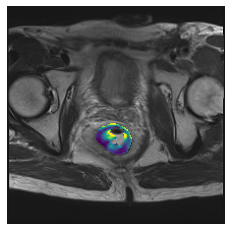

In [4]:
SLICE = 66

plt.axis('off')
plt.imshow(vol[SLICE], cmap="gray")
plt.imshow(vol_featmap[SLICE])
plt.show()

We can see that only a small part of the image is annotated with feature values, which is
what the mask is used for to filter out the rest.
Zooming in to the region-of-interest:

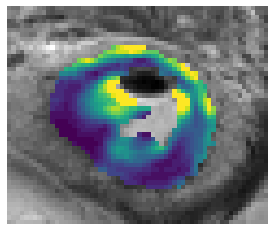

In [5]:
plt.axis('off')
plt.imshow(vol[SLICE, 110:160, 80:140], cmap="gray")
plt.imshow(vol_featmap[SLICE, 110:160, 80:140])
plt.show()

Let's pass the entire image, feature map, and mask into RADISTAT.

In [6]:
img = vol[SLICE, :, :]
mask = vol_mask[SLICE, :, :]
featmap = vol_featmap[SLICE, :, :]

result = radistat(img, mask, featmap)

Computing superpixel clusters...

Partitioning clusters into expression levels...

Calculating RADISTAT metrics...


Running `radistat()` produces a `RadistatResult` object that carries all the metrics computed by RADISTAT.

Specfically, there are 3 objects of interest.

The first is the cluster labeling produced by the internal SLIC algorithm.

In [7]:
result.supervoxel_labels

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

If we plot this against the image, we can see the various clusters being formed.
Note that a value of 0 means that pixel is not in the ROI. Again, let's zoom into the ROI.

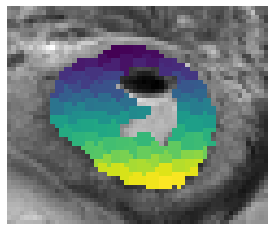

In [8]:
# Add mask that turns 0 labels into NaNs
labels_masked = np.ma.masked_where(result.supervoxel_labels == 0, result.supervoxel_labels)

plt.axis('off')
plt.imshow(img[110:160, 80:140], cmap="gray")
plt.imshow(labels_masked[110:160, 80:140])
plt.show()

After segmenting the image, RADISTAT bins each pixel's feature expression level into one of a certain number of bins, usually 3 ("low", "medium", "high") but this can be customized.
See radistat.py for parameters `radistat()` takes.

One of the metrics RADISTAT then computes is the proportion of each expression level.

In [9]:
result.texture_vec

array([0.29778934, 0.39791938, 0.30429129])

We can graph this:

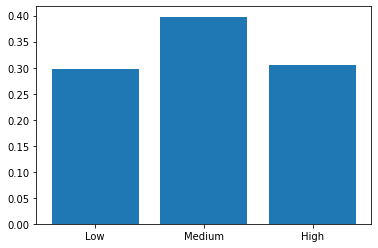

In [10]:
x = np.arange(3)
plt.bar(x, result.texture_vec, tick_label=['Low', 'Medium', 'High'])
plt.show()

Lastly, RADISTAT also computes the _adjacencies_ between different experssion level clusters.
For example, how many low-level clusters have a medium-level cluster next to them?
It stores the proportions of each adjacency type in a dictionary.

In [11]:
result.spatial_vec

{(1.0, 2.0): 0.35, (1.0, 3.0): 0.2, (2.0, 3.0): 0.45}

The entry for `(1.0, 2.0)` represents the proprtion of adjacencies between low- and medium-level clusters.
Again, we can graph this:

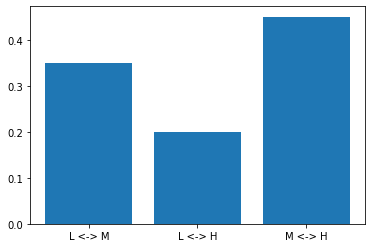

In [12]:
x = np.arange(3)
plt.bar(x, result.spatial_vec.values(), tick_label=['L <-> M', 'L <-> H', 'M <-> H'])
plt.show()